In [145]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xgboost as xgb
import wandb
import pickle

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from wandb.xgboost import wandb_callback

In [3]:
# Import all the datasets provided from Kaggle
holiday_events_data = pd.read_csv("kaggle_data/holidays_events.csv", parse_dates=["date"])
oil_data = pd.read_csv("kaggle_data/oil.csv", parse_dates=["date"])
stores_data = pd.read_csv("kaggle_data/stores.csv")
transactions_data = pd.read_csv("kaggle_data/transactions.csv")

# For predictions/Machine Learning problem
train_data = pd.read_csv("kaggle_data/train.csv")
test_data = pd.read_csv("kaggle_data/test.csv")
sample_submission_data = pd.read_csv("kaggle_data/sample_submission.csv")

In [264]:
holiday_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
# dcoilwtico column is the Daily oil price. Includes values during both the train and test data timeframes
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
# Type is the grocery store chain potentially where A Megamaxi, B Gran Aki, C SuperMaxi, D Aki, E Super Aki
# Cluster is a grouping of similar stores
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
stores_data["city"].value_counts()

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: city, dtype: int64

In [8]:
stores_data.shape

(54, 5)

In [9]:
transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
transactions_data["date"].min()

'2013-01-01'

In [11]:
transactions_data["date"].max()

'2017-08-15'

Now lets look into the data. 

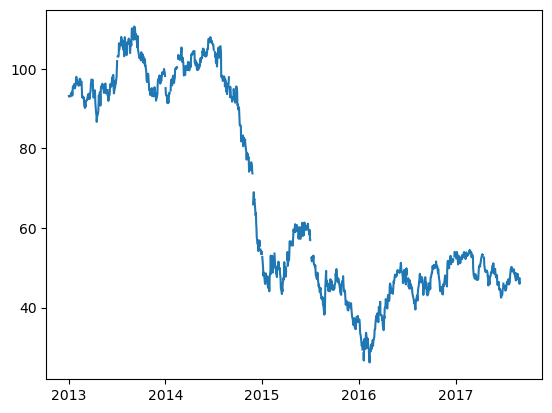

In [12]:
# The problem states that Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.
# So, we should look into the relationship between oil and transactions to confirm this.

plt.plot(oil_data["date"], oil_data["dcoilwtico"])

In [13]:
# Transactions data has a lot of rows for each store. If we want to find the relationshop between oil prices and transactions, one method 
# would be to take the average transactions of all the stores to see if it had an economical impact on the economy in Ecuador. 
transactions_sum_data = transactions_data.groupby("date")["transactions"].mean()

# We need to do an inner join and only the transaction sums with 
transactions_sum_data


date
2013-01-01     770.000000
2013-01-02    2026.413043
2013-01-03    1706.608696
2013-01-04    1706.391304
2013-01-05    2034.195652
                 ...     
2017-08-11    1658.351852
2017-08-12    1665.314815
2017-08-13    1592.462963
2017-08-14    1582.370370
2017-08-15    1602.981481
Name: transactions, Length: 1682, dtype: float64

In [14]:
# Ask to use Tableou for data analysis, python isn't the best 

In [15]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [16]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [17]:
# Lets find the list of outlier holidays--holidays that impacted average sales. 

In [18]:
avg_sales = train_data.groupby("date")["sales"].mean()

In [19]:
def find_outliers_IQR(df):
   q1 = df.quantile(0.25)
   q3 = df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [20]:
outliers = find_outliers_IQR(avg_sales)
outliers.index
# Bad

Index(['2016-04-18', '2017-01-02', '2017-04-01', '2017-05-01', '2017-06-04'], dtype='object', name='date')

In [21]:
def find_outliers(data, window, z_thresh):
    # Calculate the rolling mean and standard deviation
    roll_mean = data.rolling(window).mean()
    roll_std = data.rolling(window).std()
    
    outliers = (np.abs(data - roll_mean) > z_thresh * roll_std)

    return data.index[outliers]

outliers = find_outliers(avg_sales, window=30, z_thresh=2.5)
print(avg_sales[outliers].head())

date
2013-06-02    357.855497
2013-09-01    359.374984
2013-12-01    391.816571
2014-01-01      4.827197
2014-03-01    511.425509
Name: sales, dtype: float64


In [22]:
avg_sales.rolling(5).std()

date
2013-01-01           NaN
2013-01-02           NaN
2013-01-03           NaN
2013-01-04           NaN
2013-01-05    111.453791
                 ...    
2017-08-11     38.672092
2017-08-12     38.175788
2017-08-13     47.043375
2017-08-14     45.716734
2017-08-15     25.042929
Name: sales, Length: 1684, dtype: float64

In [23]:
from datetime import datetime

dates = []
for i in holiday_events_data["date"]:
    dates.append(str(i.date()))
    
outlier_inds = [] 
outlier_dates = []
for i in outliers:
    if i in dates:
        outlier_inds.append(dates.index(i))
        outlier_dates.append(i)

print(outliers)

Index(['2013-06-02', '2013-09-01', '2013-12-01', '2014-01-01', '2014-03-01',
       '2014-06-01', '2014-07-01', '2014-07-02', '2014-07-06', '2014-09-01',
       '2014-09-06', '2014-09-07', '2015-01-01', '2015-03-01', '2015-05-31',
       '2015-09-06', '2016-01-01', '2016-04-02', '2016-04-03', '2016-04-17',
       '2016-04-18', '2016-09-03', '2016-09-04', '2017-01-01', '2017-04-01',
       '2017-05-01', '2017-06-04'],
      dtype='object', name='date')


In [24]:
holiday_outliers = holiday_events_data.loc[outlier_inds]
holiday_outliers = holiday_outliers.assign(avg_sales = list(avg_sales[outlier_dates]))
holiday_outliers

,date,type,locale,locale_name,description,transferred,avg_sales
92,2014-01-01,Holiday,National,Ecuador,Primer dia del ano,False,4.827197
117,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,404.310110
159,2015-01-01,Holiday,National,Ecuador,Primer dia del ano,False,7.168135
211,2016-01-01,Holiday,National,Ecuador,Primer dia del ano,False,9.221882
220,2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False,713.711414
221,2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False,755.286535
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True,6.780304
302,2017-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,821.034771
308,2017-05-01,Holiday,National,Ecuador,Dia del Trabajo,False,733.276861


In [25]:
local_holidays = holiday_events_data[holiday_events_data['locale'] == 'Local']
local_holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
...,...,...,...,...,...,...
339,2017-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
340,2017-12-06,Holiday,Local,Quito,Fundacion de Quito,True
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False


Machine Learning:

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. Favorita stores is a large Ecuadorian-based grocery retailer. 

In [26]:
# Feature engineering: colunn for is local holidays, another column for is_regional/national holidays

In [27]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [28]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [29]:
# Next, we need to map train data to stores_data to get the city, from the city, we need to map city to the local holiday city

local_holidays = holiday_events_data[holiday_events_data['locale'] == 'Local']
train_data_with_city = pd.merge(train_data, stores_data[['store_nbr', 'city']], on='store_nbr', how='left')
train_data_with_city['date'] = pd.to_datetime(train_data_with_city['date'])
local_holidays['date'] = pd.to_datetime(local_holidays['date'])

temp = local_holidays.drop(["locale", "type", "description", "transferred"], axis = 1)
temp["local_holiday"] = 1
local_holidays = temp

sales_with_holidays = pd.merge(train_data_with_city, local_holidays, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
sales_with_holidays = sales_with_holidays.drop(["locale_name"], axis = 1)
sales_with_holidays["local_holiday"] = sales_with_holidays["local_holiday"].fillna(0)

non_local_holidays = holiday_events_data[holiday_events_data['locale'] != 'Local']
non_local_holidays['date'] = pd.to_datetime(non_local_holidays['date'])

temp_2 = non_local_holidays.drop(["locale", "type", "description", "transferred"], axis = 1)
temp_2["non_local_holiday"] = 1
non_local_holidays = temp_2

sales_with_holidays = pd.merge(sales_with_holidays, non_local_holidays, left_on=['date'], right_on=['date'], how='left')
sales_with_holidays = sales_with_holidays.drop(["locale_name"], axis = 1)
sales_with_holidays["non_local_holiday"] = sales_with_holidays["non_local_holiday"].fillna(0)

/var/folders/3f/8w_4h_hj2915c7c2mpbt70sr0000gn/T/ipykernel_4604/3690293686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_holidays['date'] = pd.to_datetime(local_holidays['date'])
/var/folders/3f/8w_4h_hj2915c7c2mpbt70sr0000gn/T/ipykernel_4604/3690293686.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_local_holidays['date'] = pd.to_datetime(non_local_holidays['date'])


In [30]:
sales_with_holidays["non_local_holiday"].value_counts()

0.0    2716032
1.0     294030
Name: non_local_holiday, dtype: int64

In [31]:
sales_with_holidays.head()

,id,date,store_nbr,family,sales,onpromotion,city,local_holiday,non_local_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,0.0,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,0.0,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,0.0,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,0.0,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,0.0,1.0


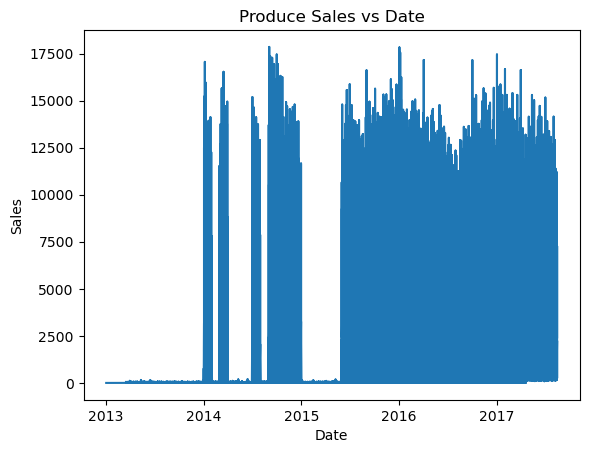

In [152]:
plt.plot(sales_with_holidays[sales_with_holidays["family"] == "PRODUCE"]["date"], sales_with_holidays[sales_with_holidays["family"] == "PRODUCE"]["sales"])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Produce Sales vs Date')
plt.show()

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

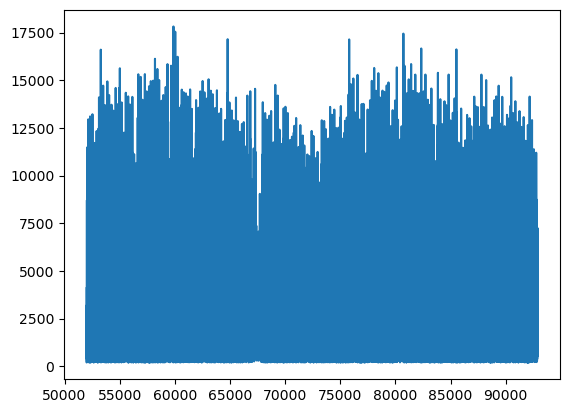

In [183]:
# lets check the ACF plots to find a method to impute the rows using more accurate data
x_part = sales_with_holidays[sales_with_holidays["family"] == "PRODUCE"]["date"]
y_part = sales_with_holidays[sales_with_holidays["family"] == "PRODUCE"]["sales"]
y_part = y_part.reset_index(drop = True)[52000:]

plt.plot(y_part)   

In [184]:
# Since the p-value is < 0.05 we can assume the time-series is stationary

# Hypothesis test
result = adfuller(y_part)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.286070
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


/Users/chrisapton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


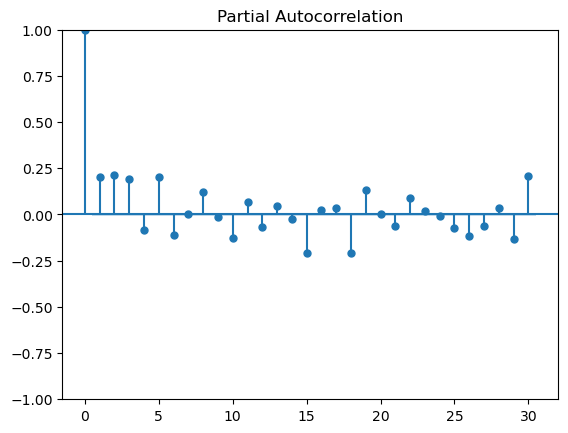

In [182]:
# Showing the PACF for fun
plot_pacf(y_part, lags=30)
plt.show()

In [48]:
# sampling the produce rows to fill the data

produce_rows = sales_with_holidays[sales_with_holidays["family"] == "PRODUCE"]
good_rows = produce_rows[produce_rows["sales"] >= 200]
bad_rows = produce_rows[produce_rows["sales"] < 200]

In [149]:
# Used auto arima to find better parameters for the arima model
#model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
# best is 5, 0, 5
print(5, 0, 5)

5 0 5


In [148]:
df = pd.DataFrame(data={'Time': good_rows["date"].values, 'Value': good_rows["sales"].values}).set_index('Time')

train_size = int(len(df) * 0.80)  # 80% for training
train, test = df[0:train_size], df[train_size:len(df)]

# Auto arima to find the best parameters



model = ARIMA(train, order=(5, 0, 5))  
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
predictions_df = pd.DataFrame(predictions.values, index=test.index, columns=['Prediction'])

/Users/chrisapton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chrisapton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chrisapton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chrisapton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an int

It turned out, the arima model didn't really do much better than just taking the mean of the data. So, just to make things easier, I'll just impute the data using the mean. 

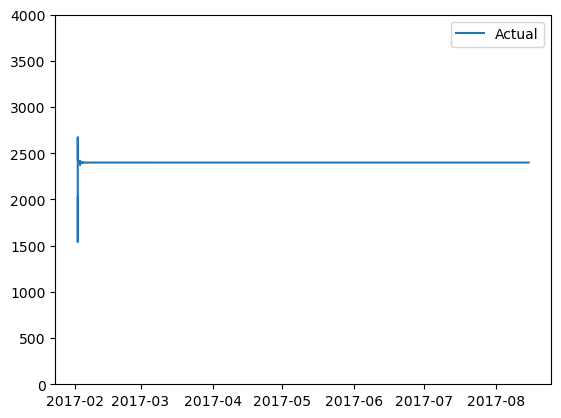

In [151]:
# Plot the ARIMA model predictions to show it's unusefulness
plt.plot(predictions_df["Prediction"].index, predictions_df["Prediction"].values, label='Actual')
plt.legend(loc='best')
plt.ylim(0, 4000)
plt.show()

In [178]:
# Comparing the line to the mean of the data the ARIMA model was trained from.
print(np.mean(good_rows["sales"]))

2409.716470790755

In [185]:
# Can ignore, testing code

#temp = model_fit.predict(start=len(train), end=len(train) + len(bad_rows["sales"]) - 1, typ='levels')
#counter = 0
#for i in list(bad_rows["sales"].index):
#    bad_rows["sales"][i] = temp.values[counter]
#    counter += 1

In [180]:
# I'll just impute by mean
for i in list(bad_rows["sales"].index):
    bad_rows["sales"][i] = np.mean(good_rows["sales"])

updated_produce = pd.concat([good_rows, bad_rows])
updated_produce = updated_produce.drop(["date", "store_nbr", "family", "onpromotion", "city", "local_holiday", "non_local_holiday"], axis = 1)

df_merged = pd.merge(sales_with_holidays, updated_produce, left_on=['id'], right_on=['id'], how='left')
df_merged['sales'] = df_merged['sales_y'].where(df_merged['sales_y'].notna(), df_merged['sales_x'])
df_merged = df_merged.drop(['sales_x', 'sales_y'], axis=1)
sales_with_holidays = df_merged
data = sales_with_holidays

/var/folders/3f/8w_4h_hj2915c7c2mpbt70sr0000gn/T/ipykernel_4604/3025343523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_rows["sales"][i] = np.mean(good_rows["sales"])


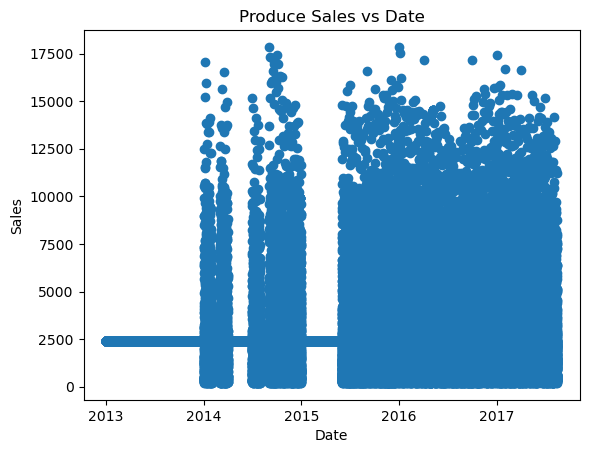

In [186]:
plt.plot(sales_with_holidays[sales_with_holidays["family"] == "PRODUCE"]["date"], sales_with_holidays[sales_with_holidays["family"] == "PRODUCE"]["sales"], 'o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Produce Sales vs Date')
plt.show()

In [187]:
def fill_na_with_avg(series):
    for idx, value in series[series.isnull()].iteritems():
        # get indices of non-NaN neighbors
        idx_before = series.loc[:idx].last_valid_index()
        idx_after = series.loc[idx:].first_valid_index()

        if pd.isnull(idx_before) and pd.isnull(idx_after):  # if no non-NaN neighbors
            continue
        elif pd.isnull(idx_before):  # if no non-NaN before
            series[idx] = series[idx_after]
        elif pd.isnull(idx_after):  # if no non-NaN after
            series[idx] = series[idx_before]
        else:  # if non-NaN neighbors exist before and after
            series[idx] = (series[idx_before] + series[idx_after]) / 2
    return series

In [188]:
# Next, lets add oil price
# First, we need to remove the NaN values in the oil-data by taking the average values from before/after
oil_data["dcoilwtico"] = fill_na_with_avg(oil_data["dcoilwtico"])
print(sum(oil_data["dcoilwtico"].isnull()))

sales_with_holidays = pd.merge(sales_with_holidays, oil_data, left_on=['date'], right_on=['date'], how='left')
sales_with_holidays = sales_with_holidays.rename(columns={'dcoilwtico': 'oil_price'})
sales_with_holidays.head()

/var/folders/3f/8w_4h_hj2915c7c2mpbt70sr0000gn/T/ipykernel_4604/2859325137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[idx] = series[idx_after]
/var/folders/3f/8w_4h_hj2915c7c2mpbt70sr0000gn/T/ipykernel_4604/2859325137.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[idx] = (series[idx_before] + series[idx_after]) / 2


0


,id,date,store_nbr,family,onpromotion,city,local_holiday,non_local_holiday,sales,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0,Quito,0.0,1.0,0.0,93.14
1,1,2013-01-01,1,BABY CARE,0,Quito,0.0,1.0,0.0,93.14
2,2,2013-01-01,1,BEAUTY,0,Quito,0.0,1.0,0.0,93.14
3,3,2013-01-01,1,BEVERAGES,0,Quito,0.0,1.0,0.0,93.14
4,4,2013-01-01,1,BOOKS,0,Quito,0.0,1.0,0.0,93.14


In [347]:
# sales_with_holidays

In [348]:
# Thing I realized, trying to use these other datasets into the train data wont help since it doesn't work with the test data. I'll just use the 
# Train data originally and scrap the work above. The only cleaning so far will be on the Produce Sales. 

In [349]:
# I can still use stores_data to add the city, type and cluster to the data

In [189]:
data = data.drop(["id", "local_holiday", "non_local_holiday", "city"], axis = 1)
data

,date,store_nbr,family,onpromotion,sales
0,2013-01-01,1,AUTOMOTIVE,0,0.000
1,2013-01-01,1,BABY CARE,0,0.000
2,2013-01-01,1,BEAUTY,0,0.000
3,2013-01-01,1,BEVERAGES,0,0.000
4,2013-01-01,1,BOOKS,0,0.000
...,...,...,...,...,...
3011725,2017-08-15,9,POULTRY,0,438.133
3011726,2017-08-15,9,PREPARED FOODS,1,154.553
3011727,2017-08-15,9,PRODUCE,148,2419.729
3011728,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000


In [190]:
# Cleaning function
def clean_data(data):
    temp = pd.merge(data, stores_data, left_on=['store_nbr'], right_on=['store_nbr'], how='left')
    temp['year'] = temp['date'].dt.year
    temp['month'] = temp['date'].dt.month
    temp['day'] = temp['date'].dt.day
    temp['dayofweek'] = temp['date'].dt.dayofweek
    temp['date'] = temp['date'].astype(int) / 10**9
    temp = pd.get_dummies(temp, columns=['store_nbr', 'family', 'city', 'state', 'type', 'cluster'])
    return temp

In [191]:
train_data = clean_data(data)
train_data.head()

,date,onpromotion,sales,year,month,day,dayofweek,store_nbr_1,store_nbr_2,store_nbr_3,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,1.356998e+09,0,0.0,2013,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.356998e+09,0,0.0,2013,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.356998e+09,0,0.0,2013,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.356998e+09,0,0.0,2013,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1.356998e+09,0,0.0,2013,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [247]:
# Can ignore, just for fun
# Start off with simple linear regression
#from sklearn.linear_model import LinearRegression
#reg = LinearRegression().fit(X, y)


0.5892504542876198

In [201]:
# ARIMAX code here

df = train_data[0:100]

# Selecting endogenous and exogenous variables
y = df["sales"]
X = df.drop(["sales"], axis = 1)


# Splitting into train and test (example: 80% for train, 20% for test)
train_size = int(len(df) * 0.8)
train_endog, test_endog = y[:train_size], y[train_size:]
train_exog, test_exog = X[:train_size], X[train_size:]

model = SARIMAX(train_endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=train_exog)
model_fit = model.fit(disp=False)

predictions = model_fit.predict(start=len(train_exog), end=len(train_exog) + len(test_exog)-1, exog=test_exog)


In [219]:
start = len(train)
end = start + len(X_test) + len(test_exog) - 1 - (643078 - 602346)
model_fit.predict(start, end, exog=X_test)

40792     4.173944e+05
40793     4.173613e+05
40794     4.177396e+05
40795     4.173448e+05
40796     4.173771e+05
              ...     
602421    6.171017e+06
602422    6.170884e+06
602423    6.170761e+06
602424    6.171259e+06
602425    6.170462e+06
Name: predicted_mean, Length: 561634, dtype: float64

In [ ]:

y = train_data["sales"]
X = train_data.drop(["sales"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [228]:
model = xgb.XGBRegressor()
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [263]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 262.566972


In [262]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9989728848404914
0.9467731620600427


In [231]:
# cleaning test data
test_data = pd.read_csv("kaggle_data/test.csv")
test_data['date'] = pd.to_datetime(test_data['date'])
ids = test_data["id"]
test_data = test_data.drop(["id"], axis = 1)
test_data = clean_data(test_data)
test_data.head()

,date,onpromotion,year,month,day,dayofweek,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,1.502842e+09,0,2017,8,16,2,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.502842e+09,0,2017,8,16,2,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.502842e+09,2,2017,8,16,2,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.502842e+09,20,2017,8,16,2,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1.502842e+09,0,2017,8,16,2,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [259]:
X_pred = test_data
y_pred = model.predict(X_pred)

In [265]:
y_pred[0:10]

array([5.05133152e+00, 4.53193426e-01, 5.93075895e+00, 2.78621167e+03,
       5.79575479e-01, 2.54842499e+02, 1.30977373e+01, 1.00554034e+03,
       7.96895386e+02, 1.42761551e+02], dtype=float32)

In [261]:
# Saving Kaggle Submission
y_pred_series = pd.Series(y_pred)
result = pd.concat([ids, y_pred_series], axis=1)
result.columns = ["id", "sales"]
result.to_csv('submission.csv', index=False)

In [245]:
result.head()

,id,sales
0,3000888,-17.826202
1,3000889,-21.600533
2,3000890,-43.882450
3,3000891,2500.635986
4,3000892,-28.627560


In [251]:
# configuration for the sweep
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'rmse',
      'goal': 'minimize'   
    },
    'parameters': {
        'max_depth': {
            'values': [3, 6, 9, 12]
        },
        'eta': {
            'values': [0.001, 0.01, 0.1]
        },
        'subsample': {
            'values': [0.5, 0.7, 1]
        },
        'colsample_bytree': {
            'values': [0.5, 0.7, 1]
        },
    }
}

# initialize a new sweep
sweep_id = wandb.sweep(sweep_config, project="XGBoost_sweeps")

wandb: ERROR Error while calling W&B API: An internal error occurred. Please contact support. (<Response [500]>)


Create sweep with ID: avviue94
Sweep URL: https://wandb.ai/chrisapton/XGBoost_sweeps/sweeps/avviue94


In [ ]:
from xgboost.callback import TrainingCallback

class WandbCallback(TrainingCallback):
    def after_iteration(self, model, epoch, evals_log):
        for data, metric in evals_log.items():
            for metric_name, log in metric.items():
                wandb.log({f"{data}-{metric_name}": log[-1]})
        return False

def train():
    with wandb.init() as run:
        params = {
            'max_depth': run.config.max_depth,
            'eta': run.config.eta,
            'subsample': run.config.subsample,
            'colsample_bytree': run.config.colsample_bytree,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        bst = xgb.train(params, dtrain, evals=[(dtest, "test")], callbacks=[WandbCallback()])

wandb.agent(sweep_id, train)

In [257]:
# optimal hyperparameters
optimal_max_depth = 30
optimal_eta = 0.05
optimal_subsample = 1
optimal_colsample_bytree = 1

model = xgb.XGBRegressor(eta = optimal_eta, max_depth = optimal_max_depth, subsample = optimal_subsample, colsample_bytree = optimal_colsample_bytree)
model.fit(X_train,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=30, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [258]:
# Save the model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Load the model
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)